# CONSTANTS

In [1]:
import CONSTANTS as c

NR_OF_ENSEMBLED_MODELS = c.NR_OF_ENSEMBLED_MODELS
DATA_AUGMENTATION_BASE_MODEL_PATH = c.DATA_AUGMENTATION_BASE_MODEL_PATH 
RANDOM_STATE = c.RANDOM_STATE

# LIBRARIES

In [2]:
import pandas as pd

import numpy as np

from imblearn.under_sampling import RandomUnderSampler,TomekLinks, NearMiss,EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN, CondensedNearestNeighbour, OneSidedSelection, NeighbourhoodCleaningRule

import tensorflow as tf

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# DATA SOURCE

In [3]:
X = np.load(r'C:\Users\yunus\Desktop\Feature Engineered Data\X.npy')
Y = np.load(r'C:\Users\yunus\Desktop\Feature Engineered Data\Y.npy')
X_TIME = np.load(r'C:\Users\yunus\Desktop\Feature Engineered Data\X_TIME.npy')

In [4]:
Y = Y[:,0,:,0]
X = X[:,:,:,0]

Y  = Y[:, int(Y.shape[1]/2):]

# PREPROCESSING

In [5]:
Y_ORDINAL = np.sum(Y,axis = 1)
Y_ORDINAL = np.expand_dims(a= Y_ORDINAL, axis = 1)

X_RESHAPED = np.reshape(X,(X.shape[0], -1))
X_RESHAPED = np.concatenate((X_RESHAPED,X_TIME), axis = 1)

In [6]:
def aGetResampledDatasets(oResampler):
    X_to_return = []
    X_TIME_to_return = []
    Y_to_return = []
    for i in range(NR_OF_ENSEMBLED_MODELS):
        X_res, y_res = oResampler.fit_resample(X_RESHAPED, Y_ORDINAL)

        X_TIME_to_add = X_res[:, -X_TIME.shape[1]:]
        X_to_add = X_res[:, :-X_TIME.shape[1]]
        X_to_add = np.reshape(X_to_add, (-1, X.shape[1], X.shape[2]))
        Y_to_add = np.zeros((y_res.shape[0], Y.shape[1]) )

        aUniqueVals = np.unique(y_res, return_counts=False)
        for iLabel in aUniqueVals:
            aIndicesToAdjust = np.where(y_res == iLabel)[0]
            Y_to_add[aIndicesToAdjust,:int(iLabel)] = 1
            
            
        X_to_return.append(X_to_add)
        X_TIME_to_return.append(X_TIME_to_add)
        Y_to_return.append(Y_to_add)
        
    X_to_return = np.array(X_to_return)
    X_TIME_to_return = np.array(X_TIME_to_return)
    Y_to_return = np.array(Y_to_return)
        
    return X_to_return, X_TIME_to_return, Y_to_return
        
        
oRus = RandomUnderSampler(random_state=RANDOM_STATE)
X_rus, X_TIME_rus, Y_rus = aGetResampledDatasets(oRus)

# oTomL = TomekLinks() # too slow, check.
# X_toml, X_TIME_toml, Y_toml = aGetResampledDatasets(oTomL)

# oNm1 = NearMiss(version = 1)
# X_nm1, X_TIME_nm1, Y_nm1 = aGetResampledDatasets(oNm1)

# oNm2 = NearMiss(version = 2)
# X_nm2, X_TIME_nm2, Y_nm2 = aGetResampledDatasets(oNm2)

# oNm3 = NearMiss(version = 3) # gives warning, check.
# X_nm3, X_TIME_nm3, Y_nm3 = aGetResampledDatasets(oNm3)

# oEnn = EditedNearestNeighbours(kind_sel="mode") # slow
# X_enn, X_TIME_enn, Y_enn = aGetResampledDatasets(oEnn)

# oRenn = RepeatedEditedNearestNeighbours()
# X_renn, X_TIME_renn, Y_renn = aGetResampledDatasets(oRenn)

# oAknn = AllKNN()
# X_aknn, X_TIME_aknn, Y_aknn = aGetResampledDatasets(oAknn)

# oCondnn = CondensedNearestNeighbour(random_state=RANDOM_STATE) #slow
# X_condnn, X_TIME_condnn, Y_condnn = aGetResampledDatasets(oCondnn)

# oOss = OneSidedSelection(random_state=RANDOM_STATE)
# X_oss, X_TIME_oss, Y_oss = aGetResampledDatasets(oOss)

# oNncr = NeighbourhoodCleaningRule()
# X_nncr, X_TIME_nncr, Y_nncr = aGetResampledDatasets(oNncr)

# ANALYSIS

## Bagging

In [ ]:
dicModels = {}
dicModelEpcochs = {}
for i in range(NR_OF_ENSEMBLED_MODELS):
    
    print(i)
    oModel = tf.keras.models.load_model(DATA_AUGMENTATION_BASE_MODEL_PATH)

    # fit model
    oModel.fit(
        X_rus[i], 
        Y_rus[i], 
        epochs= 10**2, 
        batch_size=2**5, 
        verbose=0
    )
    
    dicModels[i] = oModel
    dicModelEpcochs[i] = pd.DataFrame(dicModels[i].history.history)

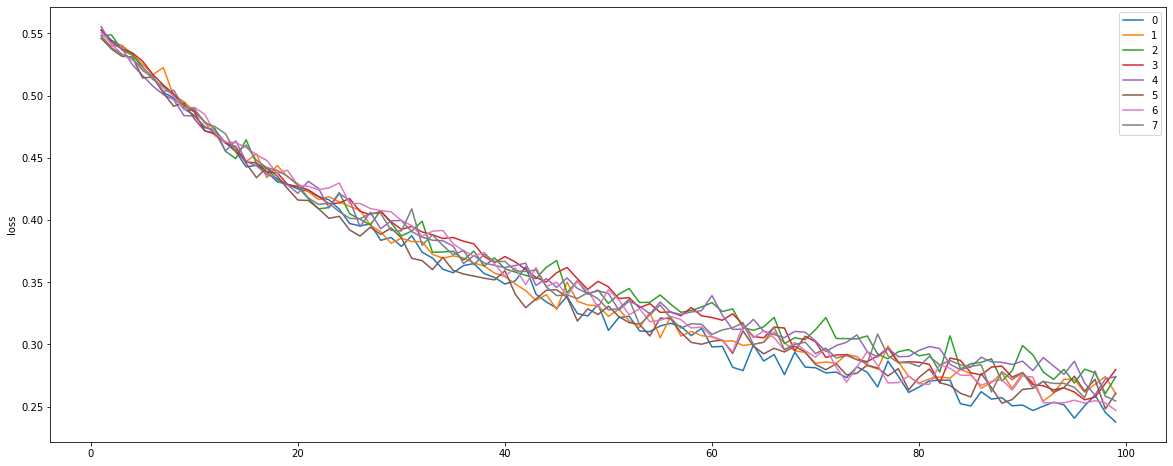

449/449 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     12588
           1       0.48      0.76      0.59      3900
           2       0.46      0.88      0.60      1426
           3       0.54      0.95      0.68       693
           4       0.69      0.95      0.80       402

   micro avg       0.72      0.92      0.81     19009
   macro avg       0.61      0.90      0.72     19009
weighted avg       0.76      0.92      0.83     19009
 samples avg       0.73      0.82      0.75     19009



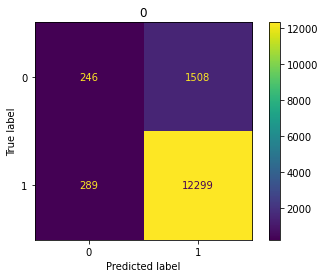

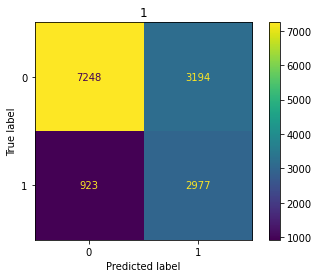

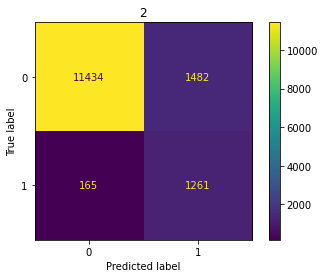

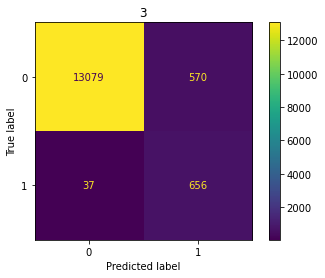

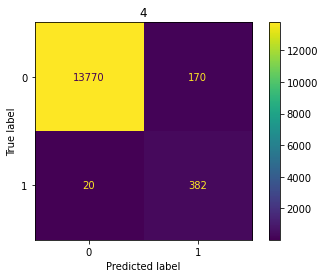

In [8]:
plt.figure(figsize = (20, 8))
# show epoch history
for i in range(NR_OF_ENSEMBLED_MODELS):
    sns.lineplot(data =  dicModelEpcochs[i]['loss'].iloc[1:], legend = True, label = str(i))
plt.show()
    
# test  
pred = np.zeros((Y.shape[0], NR_OF_ENSEMBLED_MODELS ,Y.shape[1]))
for i in range(NR_OF_ENSEMBLED_MODELS):
    pred[:, i,:] =  dicModels[i].predict(X)

pred = np.mean(pred, axis = 1)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0


ground_true = Y
print(classification_report(ground_true, pred, zero_division = 0))

# confusion matrix
for i in range(pred.shape[1]):
    oCm = confusion_matrix(ground_true[:, i], pred[:, i])
    oFig = ConfusionMatrixDisplay(confusion_matrix=oCm)
    oFig.plot()
    oFig.ax_.set_title('{}'.format(i))
    plt.show()

# SAVE

In [9]:
np.save(r'C:\Users\yunus\Desktop\Augmented Data\Bagging\Y_rus.npy', Y_rus)
np.save(r'C:\Users\yunus\Desktop\Augmented Data\Bagging\X_rus.npy', X_rus)
np.save(r'C:\Users\yunus\Desktop\Augmented Data\Bagging\X_TIME_rus.npy', X_TIME_rus)